In [ ]:
!pip install -q torch torchvision pandas scikit-learn

from google.colab import drive
drive.mount("/content/drive")

import os
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision import models

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


Mounted at /content/drive


In [ ]:
ROOT = "/content/drive/MyDrive/Car_Damage_Project"

TRAIN_CSV = os.path.join(ROOT, "CarDD_classification_train.csv")
TEST_CSV  = os.path.join(ROOT, "CarDD_classification_test.csv")

TRAIN_IMG_DIR = os.path.join(ROOT, "train2017")
TEST_IMG_DIR  = os.path.join(ROOT, "test2017")

train_df = pd.read_csv(TRAIN_CSV)
test_df  = pd.read_csv(TEST_CSV)

print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)
print("\nLabel distribution:\n", train_df["label"].value_counts())

Train shape: (2816, 2)
Test shape : (374, 2)

Label distribution:
 label
scratch          1073
dent              967
glass shatter     391
tire flat         174
crack             141
lamp broken        70
Name: count, dtype: int64


In [ ]:
classes = sorted(train_df["label"].unique().tolist())
label2idx = {lbl: i for i, lbl in enumerate(classes)}
idx2label = {i: lbl for lbl, i in label2idx.items()}
num_classes = len(classes)

print("Classes:", classes)

train_df["label_idx"] = train_df["label"].map(label2idx)
test_df["label_idx"]  = test_df["label"].map(label2idx)

# STRATIFIED split (keep class ratios)
train_split, val_split = train_test_split(
    train_df,
    test_size=0.15,
    random_state=42,
    stratify=train_df["label_idx"]
)

print("Train size:", len(train_split))
print("Val size  :", len(val_split))

Classes: ['crack', 'dent', 'glass shatter', 'lamp broken', 'scratch', 'tire flat']
Train size: 2393
Val size  : 423


In [ ]:
class CarDamageDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row["image"])

        # read image
        img = Image.open(img_path).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        label = int(row["label_idx"])
        return img, label

In [ ]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_transform = T.Compose([
    T.RandomResizedCrop(224, scale=(0.7, 1.0)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(15),
    T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),
    T.RandomAutocontrast(p=0.3),
    T.RandomAdjustSharpness(sharpness_factor=2, p=0.3),
    T.ToTensor(),
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    T.RandomErasing(p=0.25)
])

val_test_transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

train_dataset = CarDamageDataset(train_split, TRAIN_IMG_DIR, transform=train_transform)
val_dataset   = CarDamageDataset(val_split,   TRAIN_IMG_DIR, transform=val_test_transform)
test_dataset  = CarDamageDataset(test_df,     TEST_IMG_DIR,  transform=val_test_transform)

BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

len(train_loader), len(val_loader), len(test_loader)

(75, 14, 12)

In [ ]:
class_counts = train_split["label"].value_counts().reindex(classes)
print("Class counts:\n", class_counts)

inv_freq = 1.0 / class_counts.values
weights_np = inv_freq / inv_freq.sum() * len(class_counts)  # normalize a bit
class_weights = torch.tensor(weights_np, dtype=torch.float32)
print("Class weights tensor:", class_weights)

Class counts:
 label
crack            120
dent             822
glass shatter    332
lamp broken       59
scratch          912
tire flat        148
Name: count, dtype: int64
Class weights tensor: tensor([1.3382, 0.1954, 0.4837, 2.7217, 0.1761, 1.0850])


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

effnet = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

# Replace classifier head
in_features = effnet.classifier[1].in_features
effnet.classifier[1] = nn.Linear(in_features, num_classes)

effnet = effnet.to(device)

Device: cuda
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 119MB/s] 


In [ ]:
criterion = nn.CrossEntropyLoss(
    weight=class_weights.to(device),
    label_smoothing=0.1
)

optimizer = optim.SGD(
    effnet.parameters(),
    lr=0.01,
    momentum=0.9,
    weight_decay=1e-4
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", patience=3, factor=0.3
)

def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    all_labels, all_preds = [], []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            out = model(imgs)
            preds = out.argmax(dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    acc = correct / total
    return acc, np.array(all_labels), np.array(all_preds)

In [ ]:
EPOCHS = 30
best_val_acc = 0.0
patience = 6
es_counter = 0

for epoch in range(EPOCHS):
    effnet.train()
    running_loss = 0.0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        out = effnet(imgs)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    val_acc, _, _ = evaluate(effnet, val_loader)
    scheduler.step(val_acc)

    print(f"Epoch [{epoch+1}/{EPOCHS}]  Loss: {train_loss:.4f}  Val Acc: {val_acc:.4f}")

    # Early stopping & checkpoint
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        es_counter = 0
        torch.save(effnet.state_dict(), os.path.join(ROOT, "best_efficientnet_b0.pth"))
        print("  -> New best model saved.")
    else:
        es_counter += 1
        if es_counter >= patience:
            print("Early stopping triggered.")
            break

print("Best validation accuracy:", best_val_acc)

Epoch [1/30]  Loss: 1.6417  Val Acc: 0.4113
  -> New best model saved.
Epoch [2/30]  Loss: 1.3783  Val Acc: 0.6076
  -> New best model saved.
Epoch [3/30]  Loss: 1.2710  Val Acc: 0.6194
  -> New best model saved.
Epoch [4/30]  Loss: 1.1814  Val Acc: 0.7045
  -> New best model saved.
Epoch [5/30]  Loss: 1.1447  Val Acc: 0.6738
Epoch [6/30]  Loss: 1.0784  Val Acc: 0.7281
  -> New best model saved.
Epoch [7/30]  Loss: 1.0625  Val Acc: 0.7305
  -> New best model saved.
Epoch [8/30]  Loss: 1.0573  Val Acc: 0.7447
  -> New best model saved.
Epoch [9/30]  Loss: 1.0211  Val Acc: 0.7281
Epoch [10/30]  Loss: 1.0152  Val Acc: 0.7423
Epoch [11/30]  Loss: 0.9995  Val Acc: 0.7352
Epoch [12/30]  Loss: 0.9843  Val Acc: 0.7305
Epoch [13/30]  Loss: 0.9743  Val Acc: 0.7541
  -> New best model saved.
Epoch [14/30]  Loss: 0.9440  Val Acc: 0.7565
  -> New best model saved.
Epoch [15/30]  Loss: 0.9466  Val Acc: 0.7589
  -> New best model saved.
Epoch [16/30]  Loss: 0.9397  Val Acc: 0.7494
Epoch [17/30]  Loss


Final EfficientNet-B0 TEST Accuracy: 0.767379679144385

Classification report:

               precision    recall  f1-score   support

        crack       0.55      0.52      0.54        21
         dent       0.78      0.73      0.76       128
glass shatter       0.92      0.98      0.95        56
  lamp broken       0.23      0.46      0.31        13
      scratch       0.81      0.75      0.78       131
    tire flat       0.88      0.92      0.90        25

     accuracy                           0.77       374
    macro avg       0.69      0.73      0.70       374
 weighted avg       0.78      0.77      0.77       374



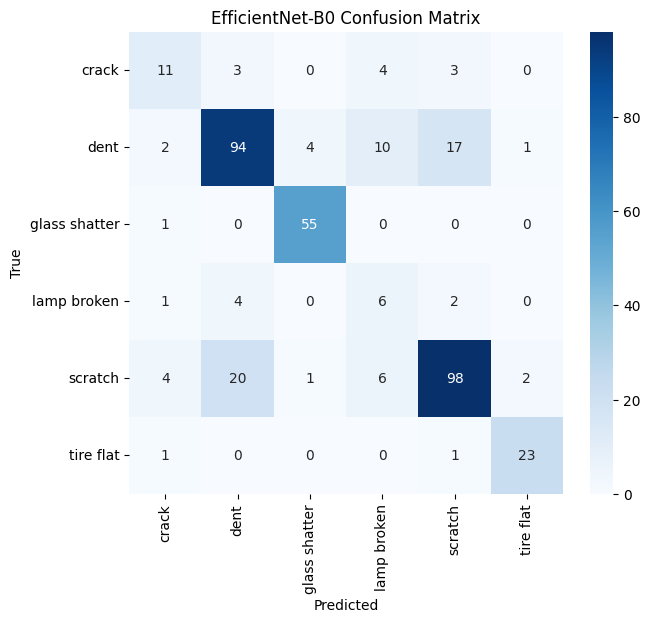

In [ ]:
effnet.load_state_dict(torch.load(os.path.join(ROOT, "best_efficientnet_b0.pth"), map_location=device))

test_acc, y_true, y_pred = evaluate(effnet, test_loader)
print("\nFinal EfficientNet-B0 TEST Accuracy:", test_acc)

print("\nClassification report:\n")
print(classification_report(y_true, y_pred, target_names=classes))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=classes, yticklabels=classes, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("EfficientNet-B0 Confusion Matrix")
plt.show()